In [5]:
import cobra
import os
from os.path import join
from cobra import Reaction, Metabolite
from cobra.util.solver import linear_reaction_coefficients
import cameo
from cameo.flux_analysis import phenotypic_phase_plane
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
#pd.set_option('display.max_rows', None)

#### Validate model

In [7]:
#cobra.io.sbml.validate_sbml_model('bit25955-sup-0003-suppdata-s3.xml')

#### Read model. (To see the difference in quality you can go to https://memote.io/report/91469ff7-ef93-456f-bc3d-ac7b3b749b1e which shows the quality score for Candida Tropicalis and https://memote.io/report/f532d83b-1fe0-4c6a-b8cf-c7d3d60601fb to see the quality score for Saccharomyces cerevisiae, which has much higher score that Candida Tropicalis. 

In [6]:
sac_model = cobra.io.read_sbml_model(join( "bit25955-sup-0003-suppdata-s3.xml"))

Model does not contain SBML fbc package information.
'' is not a valid SBML 'SId'.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_ficytc_m "Ferricytochrome c">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_lac_DASH_D_c "D-Lactate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_focytc_m "Ferrocytochrome c">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_pyr_c "Pyruvate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_h_c "H+">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_13BDglcn_c "1,3-beta-D-Glucan">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_h2o_c "H2O">
Use of C

In [7]:
sac_model = tropimodel # If we want to use the model from Candida Tropicalis

# Add reactions 

### Step 1: Fatty acid synthase subunit alpha (https://www.uniprot.org/uniprot/G8BAW7), this is from Candida parapsilosis but I think it is also in Candida Tropicalis but perhaps have not been measured yet? Since the beta subunit is in Candida Tropicalis. Here is link for alpha unit in Candida Tropicalis https://www.uniprot.org/uniprot/C5M7X9, we can see the same reaction but when searching for EC:2.3.1.86 on Brenda, Candida Tropicalis is not an option to choose under organism, but the reaction occur on https://www.uniprot.org/uniprot/C5M7X9. It should be HexA, since this makes it to hexanoic acid - so correct gene should be found but reaction is the same here anyway.

### Catalizes Hexanoic acyl-Coa (a long-chain fatty acyl-CoA) from Acetyl-Coa, malonyl-CoA and NADPH. 

### Location: Cytosol

In [8]:
caproiccoa_c = Metabolite(id='caproiccoa_c', compartment='c', formula='C27H46N7O17P3S', name = 'Hexanoyl-CoA')

In [9]:
reaction_Hexs = Reaction('HexS')
reaction_Hexs.add_metabolites({sac_model.metabolites.accoa_c: -1, sac_model.metabolites.malcoa_c: -2, sac_model.metabolites.h_c: -4,sac_model.metabolites.nadph_c: -4, caproiccoa_c: 1, sac_model.metabolites.co2_c:2, sac_model.metabolites.coa_c:2, sac_model.metabolites.h2o_c:1, sac_model.metabolites.nadp_c: 4})

In [10]:
reaction_Hexs

Reaction identifier,HexS
Name,
Memory address,0x0131d0f210
Stoichiometry,accoa_c + 4 h_c + 2 malcoa_c + 4 nadph_c --> caproiccoa_c + 2 co2_c + 2 coa_c + h2o_c + 4 nadp_c Acetyl-CoA + 4 H+ + 2 Malonyl-CoA + 4 Nicotinamide adenine dinucleotide phosphate - reduced --> Hexanoyl-CoA + 2 CO2 + 2 Coenzyme A + H2O + 4 Nicotinamide adenine dinucleotide phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [11]:
sac_model.add_reactions([reaction_Hexs])

In [12]:
sac_model.metabolites.accoa_c

Metabolite identifier,accoa_c
Name,Acetyl-CoA
Memory address,0x0131009d50
Formula,None
Compartment,c
In 22 reaction(s),"ACOATA, ACCOACr, FAS80_L, GLYATi, ACOAH, HSERTA, HMGCOASm, IPPS, ATPCL, CSNATr, DIAT, HMGCOAS, HexS, ACS, EX_accoa_LPAREN_e_RPAREN_, SPMDAT1, ACCOAtm, ACACT1, PEPAT, FAS80COA_L, ACGAM6PS, SERATi"


### Step 2: Thioesterase from fatty acid subunit beta. Acyl-CoA thioesterase hydrolyses the complex of Hexanoic acyl-Coa so hexanoic acid is formed https://www.uniprot.org/uniprot/C5MGN7. 

### Catalizes Hexanoic acid from Acetyl-Coa, malonyl-CoA and NADPH. 

### Location: Cytosol

In [13]:
caproic_c = Metabolite(id='caproic_c', compartment='c', formula='C6H12O2', name = 'Caproic/Hexanoic acid')

In [14]:
reaction_Thio = Reaction('Thio')
reaction_Thio.add_metabolites({caproiccoa_c: -1, sac_model.metabolites.h2o_c: -1, caproic_c :1, sac_model.metabolites.coa_c :1})

In [15]:
sac_model.add_reactions([reaction_Thio])

In [16]:
sac_model.reactions.Thio

Reaction identifier,Thio
Name,
Memory address,0x0131d4e2d0
Stoichiometry,caproiccoa_c + h2o_c --> caproic_c + coa_c Hexanoyl-CoA + H2O --> Caproic/Hexanoic acid + Coenzyme A
GPR,
Lower bound,0.0
Upper bound,1000.0


### Step 3: Here the omega-oxidation begins, where cytocrome p450 https://en.wikipedia.org/wiki/Cytochrome_P450_omega_hydroxylase adds an OH group on the terminal carbon atom of the hexanoic acid. 

### Location: Mitochondria or peroxisome? Based on search for p450 on uniprot it seems to be mitochondria, but anyway on the cytoplasmic side https://www.uniprot.org/uniprot/P37201. 


In [17]:
hydro6caproic_c = Metabolite(id='hydro6caproic_c', compartment='c', formula='C6H12O3', name = '6-Hydroxycaproic acid')

In [18]:
reaction_omega_hydroxylase = Reaction('omega_hydroxylase')
reaction_omega_hydroxylase.add_metabolites({caproic_c: -1, sac_model.metabolites.o2_c: -1, sac_model.metabolites.nadph_c: -1, sac_model.metabolites.h_c: -1, hydro6caproic_c:1, sac_model.metabolites.h2o_c:1, sac_model.metabolites.nadp_c: 1})

In [19]:
sac_model.add_reactions([reaction_omega_hydroxylase])

In [20]:
sac_model.reactions.omega_hydroxylase

Reaction identifier,omega_hydroxylase
Name,
Memory address,0x0131d09550
Stoichiometry,caproic_c + h_c + nadph_c + o2_c --> h2o_c + hydro6caproic_c + nadp_c Caproic/Hexanoic acid + H+ + Nicotinamide adenine dinucleotide phosphate - reduced + O2 --> H2O + 6-Hydroxycaproic acid + Nicotinamide adenine dinucleotide phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


### Step 4: FAO converts the primary alcohol to an aldehyde. https://www.brenda-enzymes.org/enzyme.php?ecno=1.1.3.13&Suchword=&reference=&UniProtAcc=&organism%5B%5D=Candida+tropicalis 

### Location: ? 


In [21]:
oxo6caproic_c = Metabolite(id='oxo6caproic_c', compartment='c', formula='C6H10O3', name = '6-Oxocaproic acid')

In [22]:
reaction_omega_fao = Reaction('omega_fao')
reaction_omega_fao.add_metabolites({hydro6caproic_c: -1, sac_model.metabolites.o2_c: -1, sac_model.metabolites.h2o2_c: 1, oxo6caproic_c : 1})

In [23]:
sac_model.add_reactions([reaction_omega_fao])

In [24]:
sac_model.reactions.omega_fao

Reaction identifier,omega_fao
Name,
Memory address,0x013262c850
Stoichiometry,hydro6caproic_c + o2_c --> h2o2_c + oxo6caproic_c 6-Hydroxycaproic acid + O2 --> Hydrogen peroxide + 6-Oxocaproic acid
GPR,
Lower bound,0.0
Upper bound,1000.0


### Step 5: Ald dh converts the aldehyde to adipic acid https://www.brenda-enzymes.org/enzyme.php?ecno=1.2.1.48&Suchword=&reference=&UniProtAcc=&organism%5B%5D=Candida+tropicalis. 

### Location: ? 


In [25]:
adipic_acid = Metabolite(id='adipic_acid', compartment='c', formula='C6H10O4', name = 'Adipic Acid')

In [26]:
reaction_ad_dehydrogenase = Reaction('ad_dehydrogenase')
reaction_ad_dehydrogenase.add_metabolites({oxo6caproic_c: -1, sac_model.metabolites.nad_c: -1, sac_model.metabolites.h2o_c: -1,sac_model.metabolites.nadh_c: 1, sac_model.metabolites.h_c: 1, adipic_acid:1})

In [27]:
sac_model.add_reactions([reaction_ad_dehydrogenase])

In [28]:
sac_model.reactions.ad_dehydrogenase

Reaction identifier,ad_dehydrogenase
Name,
Memory address,0x0131cbb2d0
Stoichiometry,h2o_c + nad_c + oxo6caproic_c --> adipic_acid + h_c + nadh_c H2O + Nicotinamide adenine dinucleotide + 6-Oxocaproic acid --> Adipic Acid + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,
Lower bound,0.0
Upper bound,1000.0


##### Add demand reaction so that adipic acid is optimizes

In [29]:
demand = sac_model.add_boundary(sac_model.metabolites.adipic_acid, type = 'demand')

##### Check if the organism can produce adipic acid

In [30]:
with sac_model:
    sac_model.objective = demand
    print(sac_model.slim_optimize())
    sac_model.optimize()

10.5235


### If we use the genome-model from candida tropicalis we can get  10.5235 mmol adipic acid per hour per biomass, but there was some quality issues with this model that needs to be considered. 

### If we use the genome-model from Saccharomyces cerevisiae, we only get 1.33 mmol adipic acid per hour per biomass, but this model had much higher quality score from memote. 

#### We also have to add an exchange reaction for adipic acid so it can leave the system

In [31]:
reaction_adipic_acid_ex = Reaction('adipic_acid_ex')
reaction_adipic_acid_ex.add_metabolites({adipic_acid:-1})

In [32]:
sac_model.add_reactions([reaction_adipic_acid_ex])

In [33]:
sac_model.reactions.adipic_acid_ex

Reaction identifier,adipic_acid_ex
Name,
Memory address,0x0132624bd0
Stoichiometry,adipic_acid --> Adipic Acid -->
GPR,
Lower bound,0.0
Upper bound,1000.0


### Make a phase plane calculation

In [43]:
result = phenotypic_phase_plane(sac_model,
                                variables=[sac_model.reactions.BIOMASS],
                                objective=sac_model.reactions.adipic_acid_ex)

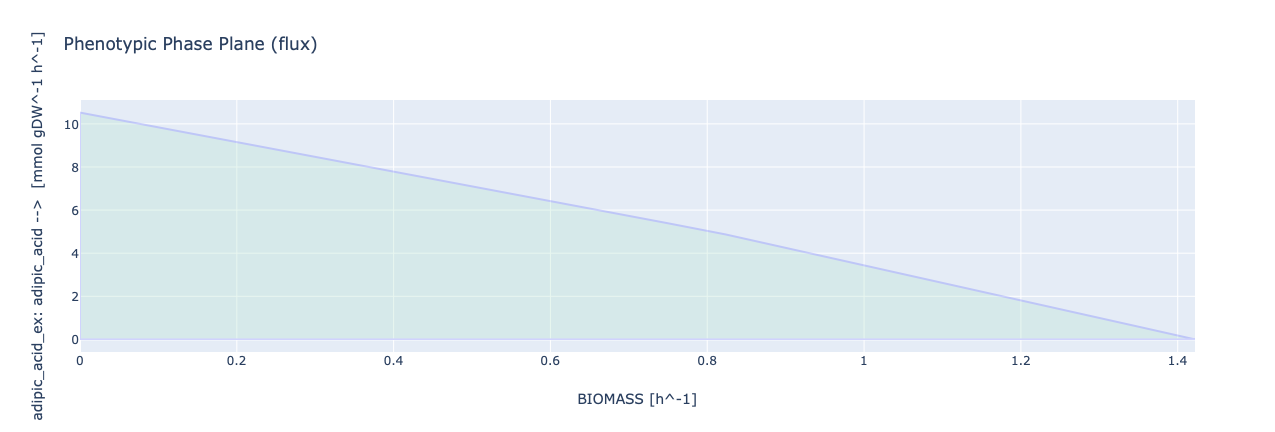

In [44]:
result.plot()

In [45]:
result.data_frame

,BIOMASS,objective_lower_bound,objective_upper_bound,c_yield_lower_bound,c_yield_upper_bound,mass_yield_lower_bound,mass_yield_upper_bound
0,0.000000,0.0,1.052350e+01,NaN,NaN,NaN,NaN
1,0.074846,0.0,1.001099e+01,NaN,NaN,NaN,NaN
2,0.149693,0.0,9.498487e+00,NaN,NaN,NaN,NaN
3,0.224539,0.0,8.985980e+00,NaN,NaN,NaN,NaN
4,0.299385,0.0,8.473473e+00,NaN,NaN,NaN,NaN
5,0.374232,0.0,7.960967e+00,NaN,NaN,NaN,NaN
6,0.449078,0.0,7.448460e+00,NaN,NaN,NaN,NaN
7,0.523925,0.0,6.935953e+00,NaN,NaN,NaN,NaN
8,0.598771,0.0,6.423447e+00,NaN,NaN,NaN,NaN
9,0.673617,0.0,5.910940e+00,NaN,NaN,NaN,NaN


In [46]:
sac_model.summary()

In [47]:
sac_model.objective.expression

1.0*BIOMASS - 1.0*BIOMASS_reverse_69053

### Instead see what happens if we change the objective to product

In [48]:
with sac_model:
    sac_model.objective = demand
    print(sac_model.objective.expression)
    print()
    solution = sac_model.summary()
    print(((solution)))

1.0*DM_adipic_acid - 1.0*DM_adipic_acid_reverse_a182f

  IN_FLUXES   IN_FLUXES OUT_FLUXES OUT_FLUXES    OBJECTIVES   OBJECTIVES
      ID         FLUX       ID        FLUX           ID          FLUX   
         o2_e    31.6      h2o_e      36.8     DM_adipic_acid    10.5   
 glc_DASH_D_e    16.7      co2_e      36.8                        nan   
                  nan        h_e        21                        nan   


/Users/sifingibergsdottir/anaconda3/envs/cell-factory-design-course/lib/python3.7/site-packages/cobra/core/summary/summary.py:206: UserWarning:

Setting float_format to anything other than None will cause nan to be present in the output.



### But the growth rate is 0 in that case

### Therefore we need to set the growth rate

In [50]:
with sac_model:
    sac_model.objective = demand
    print(sac_model.objective.expression)
    print()
    solution = sac_model.summary()
    print(((solution)))
    
    sac_model.reactions.BIOMASS.lower_bound = 0.4
    sac_model.reactions.BIOMASS.upper_bound = 0.4
    
    print()
    solution = sac_model.summary()
    print(((solution)))
    
    # Perform FVA
    print()
    fva = flux_variability_analysis(sac_model)
    print(sac_model.summary(fva=0.95))

1.0*DM_adipic_acid - 1.0*DM_adipic_acid_reverse_a182f

  IN_FLUXES   IN_FLUXES OUT_FLUXES OUT_FLUXES    OBJECTIVES   OBJECTIVES
      ID         FLUX       ID        FLUX           ID          FLUX   
         o2_e    31.6      h2o_e      36.8     DM_adipic_acid    10.5   
 glc_DASH_D_e    16.7      co2_e      36.8                        nan   
                  nan        h_e        21                        nan   

  IN_FLUXES   IN_FLUXES OUT_FLUXES OUT_FLUXES    OBJECTIVES   OBJECTIVES
      ID         FLUX       ID        FLUX           ID          FLUX   
         o2_e    31.4      h2o_e      55.5     DM_adipic_acid    7.78   
 glc_DASH_D_e    16.7      co2_e      36.3                        nan   
        nh4_e    2.65        h_e      17.7                        nan   

  IN_FLUXES   IN_FLUXES IN_FLUXES IN_FLUXES   OUT_FLUXES   OUT_FLUXES OUT_FLUXES OUT_FLUXES    OBJECTIVES   OBJECTIVES
      ID         FLUX    FLUX_MIN  FLUX_MAX       ID          FLUX     FLUX_MIN   FLUX_MAX    